In [1]:
import bisect
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from scipy.stats import norm


data_path = 'C:\\Users\\abellahsene\\Downloads\\datasets_2880_5490_closing_odds.csv.gz'

data_columns = [
    u'match_id', u'league', u'match_date', u'home_team', u'home_score',
    u'away_team', u'away_score', u'avg_odds_home_win', u'avg_odds_draw',
    u'avg_odds_away_win', u'max_odds_home_win', u'max_odds_draw',
    u'max_odds_away_win', u'top_bookie_home_win', u'top_bookie_draw',
    u'top_bookie_away_win', u'n_odds_home_win', u'n_odds_draw', u'n_odds_away_win'
]

strategy_1 = 'strategy_beatthebookie'
strategy_2 = 'strategy_random'
RESULTS = {
    strategy_1: {
        'money': None, 
        'accuracy': None,
        'max_odds': None, 
        'mean_odds': None, 
        'ids': None
    },
    strategy_2: {
        'money': None, 
        'accuracy': None,
        'max_odds': None, 
        'mean_odds': None, 
        'ids': None
    }
}

In [19]:
class WeightedRandomGenerator(object):
    '''
    # helper function from: https://eli.thegreenplace.net/2010/01/22/weighted-random-generation-in-python
    '''
    def __init__(self, weights):
        self.totals = []
        running_total = 0

        for w in weights:
            running_total += w
            self.totals.append(running_total)

    def next(self):
        rnd = random.random() * self.totals[-1]
        return bisect.bisect_right(self.totals, rnd)

    def __call__(self):
        return self.next()

In [3]:
class ExperimentBeatTheBookie(object): 
    
    def __init__(
        self, 
        odds_bins=np.arange(0,1,0.0125), 
        min_games=100,
        bet=50,
        marg=0.05,
        n_samples=100,
        run_strategies=1,
        n_valid_odds=3
    ):
        self.odds_bins = odds_bins #probability bins
        self.min_games = min_games
        self.bet = bet # money on each bet
        self.marg = marg # margin odds above the mean.
        self.n_samples = n_samples # number of returns to calculate (with replacement) for the random strategy
        self.run_strategies=run_strategies # 1: run both strategies, 0: load results from disk
        self.n_valid_odds=n_valid_odds
        self.data = None
        self.result = None
        self.acc_home = []
        self.acc_draw = []
        self.acc_away = []
        self.bin_odds_home_mean = []
        self.bin_odds_draw_mean = []
        self.bin_odds_away_mean = []
        self.n_games = None
        self.leagues = None
        self.n_leagues = None
        self.results = RESULTS
    
    def load_data(self):
        # Fields: 
        # 1. match_table_id: unique identifier of the game
        # 2. league of the game
        # 3. match date
        # 4. home team
        # 5. 90-minute score of home team
        # 6. away team
        # 7. 90-minute score of away team
        # 8. average closing odds home win
        # 9. average closing odds draw
        # 10. average closing odds away win
        # 11. maximum offered closing odds home win
        # 12. maximum offered closing odds draw
        # 13. maximum offered closing odds away win
        # 14. name of bookmaker offering maximum closing odds for home win
        # 15. name of bookmaker offering maximum closing odds for draw
        # 16. name of bookmaker offering maximum closing odds for away win
        # 17. number of available closing odds for home win
        # 18. number of available closing odds for draw
        # 19. number of available closing odds for away win
        self.data = pd.read_csv(data_path, 
            compression='gzip', 
            sep=',', 
            quotechar='"'
        )
        # Mini cleaning
#         self.data = self.data[
#             (self.data['avg_odds_home_win'] != 0.0) 
#             & (self.data['avg_odds_draw'] != 0.0) 
#             & (self.data['avg_odds_away_win'] != 0.0)
#         ]
        # Calculate basic stats
        self.n_games = self.data.shape[0]
        self.leagues = self.data['league']
        self.n_leagues = pd.unique(self.data['league']).shape[0]
        
        self.result = 0 * (self.data['home_score'] > self.data['away_score']) +\
            1 * (self.data['home_score'] == self.data['away_score']) +\
            2 * (self.data['home_score'] < self.data['away_score'])

    
    def beatthebookie_strategy(self):
        earn_margin_home = ((1 / self.data['avg_odds_home_win'] - self.marg) * self.data['max_odds_home_win'] - 1) * \
                            (self.data['n_odds_home_win'] > self.n_valid_odds)
        earn_margin_draw = ((1 / self.data['avg_odds_draw'] - self.marg) * self.data['max_odds_draw'] - 1) * \
                            (self.data['n_odds_draw'] > self.n_valid_odds)
        earn_margin_away = ((1 / self.data['avg_odds_away_win'] - self.marg) * self.data['max_odds_away_win'] - 1) * \
                            (self.data['n_odds_away_win'] > self.n_valid_odds)

        max_margin = np.max(
            pd.concat(
                [earn_margin_home, earn_margin_draw, earn_margin_away],
                axis=1
            ),
            axis=1
        )
        
        max_arg = pd.concat(
            [earn_margin_home, earn_margin_draw, earn_margin_away],
            axis=1
        ).apply(np.argmax,axis=1)
        
        max_margin_max_odd = (max_arg == 0) * self.data['max_odds_home_win'] + \
                             (max_arg == 1) * self.data['max_odds_draw'] + \
                             (max_arg == 2) * self.data['max_odds_away_win']
        
        max_margin_mean_odd = (max_arg == 0) * self.data['avg_odds_home_win'] + \
                             (max_arg == 1) * self.data['avg_odds_draw'] + \
                             (max_arg == 2) * self.data['avg_odds_away_win']

        should_bet = max_margin > 0
        bets_outcome = self.bet * (max_margin_max_odd - 1) * (max_arg == self.result) - self.bet * (max_arg != self.result)
        accuracy = (max_arg == self.result)[should_bet].apply(int)
        
        self.results[strategy_1]['money'] = np.cumsum(bets_outcome[should_bet])
        self.results[strategy_1]['accuracy'] = accuracy
        self.results[strategy_1]['max_odds'] = max_margin_max_odd[should_bet]
        self.results[strategy_1]['mean_odds'] = max_margin_mean_odd[should_bet]
        self.results[strategy_1]['ids'] = max_arg.iloc[np.where(should_bet)]
    
    
    def random_strategy(self, p_home, p_draw, p_away):
        money = np.zeros([self.n_samples, self.n_games])
        accuracy = np.zeros([self.n_samples, self.n_games])
        max_odds = np.zeros([self.n_samples, self.n_games])
        mean_odds = np.zeros([self.n_samples, self.n_games])
        ids = np.zeros([self.n_samples, self.n_games])

        wrg = WeightedRandomGenerator([p_home, p_draw, p_away])

        for samp in range(0, self.n_samples):
            inds = np.random.choice(range(0, self.n_games), (self.n_games), replace=False)
            sample = self.data.iloc[inds]
            sample_result = self.result.iloc[inds]
            bet_side = np.array([wrg.next() for i in range(self.n_games)])
            sample_max_odds = (bet_side == 0) * sample['max_odds_home_win'] + \
                             (bet_side == 1) * sample['max_odds_draw'] + \
                             (bet_side == 2) * sample['max_odds_away_win']
            sample_mean_odds = (bet_side == 0) * sample['max_odds_home_win'] + \
                             (bet_side == 1) * sample['max_odds_draw'] + \
                             (bet_side == 2) * sample['max_odds_away_win']

            bets_outcome = self.bet * (sample_max_odds - 1) * (sample_result == bet_side) - self.bet * (sample_result != bet_side)
            money[samp,] = np.cumsum(bets_outcome)
            accuracy[samp,] = (sample_result == bet_side).apply(int)
            max_odds[samp,] = sample_max_odds
            mean_odds[samp,] = sample_mean_odds
            ids[samp,] = bet_side
        
        self.results[strategy_2]['money'] = money
        self.results[strategy_2]['accuracy'] = accuracy
        self.results[strategy_2]['max_odds'] = max_odds
        self.results[strategy_2]['mean_odds'] = mean_odds
        self.results[strategy_2]['ids'] = ids
        
    def print_general_overview(self):
        prior_home = float(sum(self.data['home_score'] > self.data['away_score'])) / self.n_games * 100
        prior_draw = float(sum(self.data['home_score'] == self.data['away_score'])) / self.n_games * 100
        prior_away = float(sum(self.data['home_score'] < self.data['away_score'])) / self.n_games * 100

        print('Total number of Leagues : {}'.format(self.n_leagues));
        print('Total number of Games   : {}\n'.format(self.n_games)); 
        
        print('Proportion of Home wins : {:2.3f}%'.format(prior_home));
        print('Proportion of Draws     : {:2.3f}%'.format(prior_draw));
        print('Proportion of Away wins : {:2.3f}%'.format(prior_away));
        
    
    def calculate_accuracy_of_prediction(self):
        # Calculate accuracy of prediction as a function of the implicit probability 
        # contained in the odds

        # Home victory
        p_home = 1/self.data['avg_odds_home_win']
        p_draw = 1/self.data['avg_odds_draw']
        p_away = 1/self.data['avg_odds_away_win']

        home_score = self.data['home_score']
        away_score = self.data['away_score']
 
        for bn in range(0, len(self.odds_bins) - 2):
            # Get the data from the bin
            inds_home = np.where((p_home > self.odds_bins[bn]) & (p_home <= self.odds_bins[bn + 1]))[0]
            inds_draw = np.where((p_draw > self.odds_bins[bn]) & (p_draw <= self.odds_bins[bn + 1]))[0]
            inds_away = np.where((p_away > self.odds_bins[bn]) & (p_away <= self.odds_bins[bn + 1]))[0]
            # Get accuracy for home, draw away
            if (len(inds_home) >= self.min_games):
                self.acc_home.append(float(sum(home_score[inds_home] > away_score[inds_home])) / len(inds_home))
                self.bin_odds_home_mean.append(np.mean(p_home[inds_home]));
            if (len(inds_draw) >= self.min_games):
                self.acc_draw.append(float(sum(home_score[inds_draw] == away_score[inds_draw])) / len(inds_draw))
                self.bin_odds_draw_mean.append(np.mean(p_draw[inds_draw]))
            if (len(inds_away) >= self.min_games):
                self.acc_away.append(float(sum(home_score[inds_away] < away_score[inds_away])) / len(inds_away))
                self.bin_odds_away_mean.append(np.mean(p_away[inds_away]))

    def plot_accuracy_of_prediction(self):
        plt.plot(self.acc_home, self.bin_odds_home_mean,'.k')
        plt.plot(self.acc_draw, self.bin_odds_draw_mean,'.r')
        plt.plot(self.acc_away, self.bin_odds_away_mean,'.b')
        plt.show()

In [4]:
experiment = ExperimentBeatTheBookie()
experiment.load_data()
experiment.print_general_overview()

Total number of Leagues : 818
Total number of Games   : 479440

Proportion of Home wins : 45.241%
Proportion of Draws     : 24.986%
Proportion of Away wins : 29.772%


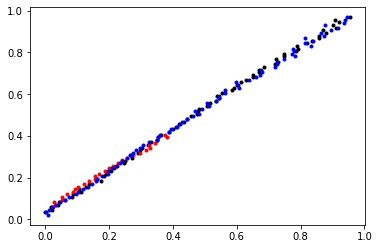

In [5]:
experiment.calculate_accuracy_of_prediction()
experiment.plot_accuracy_of_prediction()

In [6]:
experiment.beatthebookie_strategy()
p_home = np.mean(experiment.results[strategy_1]['ids'][0:]==0)
p_draw = np.mean(experiment.results[strategy_1]['ids'][0:]==1)
p_away = np.mean(experiment.results[strategy_1]['ids'][0:]==2)
print(p_home, p_draw, p_away)

C:\Users\abellahsene\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


0.5944715159032515 0.02133427837334987 0.3841942057233986


In [7]:
experiment.random_strategy(p_home, p_draw, p_away)

In [8]:
mean_s1 = np.mean(experiment.results[strategy_1]['mean_odds'])
mean_s2 = np.mean(experiment.results[strategy_2]['mean_odds'])

std_s1 = np.std(experiment.results[strategy_1]['mean_odds'])
std_s2 = np.std(experiment.results[strategy_2]['mean_odds'])

print('Strategy #1: Mean={:5.3f} | Std={:5.3f}'.format(mean_s1, std_s1))
print('Strategy #2: Mean={:5.3f} | Std={:5.3f}'.format(mean_s2, std_s2))

Strategy #1: Mean=2.304 | Std=0.991
Strategy #2: Mean=3.499 | Std=3.508


In [9]:
offsets = [-0.034, -0.057, -0.037]

s1_mean_accuracy = np.mean(experiment.results[strategy_1]['accuracy']) * 100
s1_expected_accuracy = np.mean(
    pd.concat(
        [
            (1 / experiment.results[strategy_1]['mean_odds'][experiment.results[strategy_1]['ids']==0]) + offsets[0], 
            (1 / experiment.results[strategy_1]['mean_odds'][experiment.results[strategy_1]['ids']==1]) + offsets[1], 
            (1 / experiment.results[strategy_1]['mean_odds'][experiment.results[strategy_1]['ids']==2]) + offsets[2], 
        ]
    )
) * 100
print('Strategy #1: Mean Accuracy={:5.3f}% | Expected Accuracy={:5.3f}%'.format(s1_mean_accuracy, s1_expected_accuracy))

Strategy #1: Mean Accuracy=44.364% | Expected Accuracy=45.945%


In [10]:
s2_expected_accuracies = np.zeros((experiment.n_samples))
for m in range(0, experiment.n_samples):
    odds_home = experiment.results[strategy_2]['mean_odds'][m, experiment.results[strategy_2]['ids'][m, :]==0]
    odds_draw = experiment.results[strategy_2]['mean_odds'][m, experiment.results[strategy_2]['ids'][m, :]==1]
    odds_away = experiment.results[strategy_2]['mean_odds'][m, experiment.results[strategy_2]['ids'][m, :]==2]
    s2_prob = np.concatenate(
        [
            (1 / odds_home) + offsets[0],
            (1 / odds_draw) + offsets[1], 
            (1 / odds_away) + offsets[2]
        ]
    )
    s2_expected_accuracies[m] = np.mean(s2_prob)

s2_mean_accuracy = np.mean(np.mean(experiment.results[strategy_2]['accuracy'])) * 100
s2_expected_accuracy = np.mean(s2_expected_accuracies) * 100

print('Strategy #2: Mean Accuracy={:5.3f}% | Expected Accuracy={:5.3f}%'.format(s2_mean_accuracy, s2_expected_accuracy))

C:\Users\abellahsene\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\abellahsene\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Strategy #2: Mean Accuracy=38.870% | Expected Accuracy=  inf%


In [11]:
random_strategy_mean = np.nanmean(experiment.results[strategy_2]['money'][:,-1])
random_strategy_std = np.nanstd(experiment.results[strategy_2]['money'][:,-1])

delta_sigma = (np.array(experiment.results[strategy_1]['money'])[-1] - random_strategy_mean) / random_strategy_std # distance to the mean in standard deviations

#p = norm.cdf(np.array(s1_money)[-1],random_strategy_mean,random_strategy_std)
# percentage of z values expected to lie above zσ.  CI = (−zσ, zσ)
#prop = (1 - p);
#fraction = 1 / prop; % expressed as fraction

print('Mean Odds of Our Strategy       : {:2.3f} (STD={:2.3f})'.format(mean_s1, std_s1))
print('Mean Odds of Random Bet Strategy: {:2.3f} (STD={:2.3f})'.format(mean_s2, std_s2))
print('Beat The Bookie statistics:');
print('\tTotal bets: {:2.0f} \n\tReturn    : {:2.4f}\n\tProfit    : {:2.0f}\n\tExpected Accuracy: {:2.1f}%\n\tMean Accuracy    : {:2.2f}%'.format(
    experiment.results[strategy_1]['money'].shape[0], 
    np.array(experiment.results[strategy_1]['money'])[-1]/(experiment.results[strategy_1]['money'].shape[0] * experiment.bet) * 100,
    np.array(experiment.results[strategy_1]['money'])[-1], 
    s1_expected_accuracy, 
    s1_mean_accuracy
    ) 
)

print('Random bet strategy statistics:');
print('\tTotal bets: {:2.0f} \n\tReturn    : {:2.4f}\n\tProfit    : {:2.0f}\n\tExpected Accuracy: {:2.1f}%\n\tMean Accuracy    : {:2.2f}%'.format(
    experiment.results[strategy_2]['money'].shape[1], 
    random_strategy_mean/(experiment.results[strategy_2]['money'].shape[1] * experiment.bet) * 100,
    random_strategy_mean, 
    s2_expected_accuracy, 
    s2_mean_accuracy
    ) 
)

Mean Odds of Our Strategy       : 2.304 (STD=0.991)
Mean Odds of Random Bet Strategy: 3.499 (STD=3.508)
Beat The Bookie statistics:
	Total bets: 56435 
	Return    : 3.5037
	Profit    : 98865
	Expected Accuracy: 45.9%
	Mean Accuracy    : 44.36%
Random bet strategy statistics:
	Total bets: 479440 
	Return    : -3.2971
	Profit    : -790384
	Expected Accuracy: inf%
	Mean Accuracy    : 38.87%


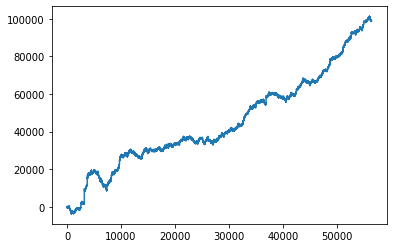

In [12]:
plt.plot(range(experiment.results[strategy_1]['money'].shape[0]), experiment.results[strategy_1]['money'])
plt.show()

In [13]:
data = pd.read_csv(data_path, 
            compression='gzip', 
            sep=',', 
            quotechar='"'
        )

In [14]:
data

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win
0,170088,England: Premier League,2005-01-01,Liverpool,0,Chelsea,1,2.9944,3.1944,2.2256,3.20,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9
1,170089,England: Premier League,2005-01-01,Fulham,3,Crystal Palace,1,1.9456,3.2333,3.6722,2.04,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9
2,170090,England: Premier League,2005-01-01,Aston Villa,1,Blackburn,0,1.8522,3.2611,4.0144,2.00,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9
3,170091,England: Premier League,2005-01-01,Bolton,1,West Brom,1,1.6122,3.4133,5.4722,1.67,3.57,6.27,Coral,Pinnacle Sports,Pinnacle Sports,9,9,9
4,170092,England: Premier League,2005-01-01,Charlton,1,Arsenal,3,5.9878,3.4778,1.5567,7.00,3.60,1.62,Expekt,Paddy Power,bet365,9,9,9
5,170093,England: Premier League,2005-01-01,Manchester City,2,Southampton,1,1.7000,3.3667,4.7344,1.73,3.50,5.00,bet365,Expekt,bet365,9,9,9
6,170094,England: Premier League,2005-01-01,Newcastle Utd,2,Birmingham,1,1.8622,3.2500,3.9622,1.91,3.40,4.33,bet365,Sportingbet,bet365,9,9,9
7,170095,England: Premier League,2005-01-01,Portsmouth,1,Norwich,1,1.6344,3.3933,5.2633,1.70,3.54,6.14,William Hill,Pinnacle Sports,Pinnacle Sports,9,9,9
8,170096,England: Premier League,2005-01-01,Tottenham,5,Everton,2,2.2156,3.1722,3.0444,2.29,3.20,3.35,Expekt,bet365,Pinnacle Sports,9,9,9
9,170097,England: Premier League,2005-01-01,Middlesbrough,0,Manchester United,2,3.3611,3.2222,2.0489,3.75,3.25,2.10,bet365,Expekt,Coral,9,9,9


In [15]:
conditions = [
    (data['home_score']>data['away_score']),
    (data['home_score'] < data['away_score']),
    (data['home_score']==data['away_score'])
]

values = ['H', 'A', 'D']
data['FTR'] = np.select(conditions, values)

In [16]:
data['date'] = pd.to_datetime(data.match_date, format='%Y-%m-%d')

In [20]:
alpha_home = 0.034
data['Prob. H'] = 1/(data.avg_odds_home_win - alpha_home)

In [22]:
alpha_away = 0.037
data['Prob. Away'] = 1/(data.avg_odds_away_win - alpha_away)
alpha_draw = 0.057
data['Prob. Draw'] = 1/(data.avg_odds_draw - alpha_draw)

In [24]:
data

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,...,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,FTR,date,Prob. H,Prob. Away,Prob. Draw
0,170088,England: Premier League,2005-01-01,Liverpool,0,Chelsea,1,2.9944,3.1944,2.2256,...,Sportingbet,Expekt,9,9,9,A,2005-01-01,0.337792,0.456913,0.318735
1,170089,England: Premier League,2005-01-01,Fulham,3,Crystal Palace,1,1.9456,3.2333,3.6722,...,bet-at-home,Expekt,9,9,9,H,2005-01-01,0.523122,0.275088,0.314832
2,170090,England: Premier League,2005-01-01,Aston Villa,1,Blackburn,0,1.8522,3.2611,4.0144,...,Paddy Power,Sportingbet,9,9,9,H,2005-01-01,0.549995,0.251421,0.312100
3,170091,England: Premier League,2005-01-01,Bolton,1,West Brom,1,1.6122,3.4133,5.4722,...,Pinnacle Sports,Pinnacle Sports,9,9,9,D,2005-01-01,0.633633,0.183986,0.297947
4,170092,England: Premier League,2005-01-01,Charlton,1,Arsenal,3,5.9878,3.4778,1.5567,...,Paddy Power,bet365,9,9,9,A,2005-01-01,0.167960,0.658025,0.292329
5,170093,England: Premier League,2005-01-01,Manchester City,2,Southampton,1,1.7000,3.3667,4.7344,...,Expekt,bet365,9,9,9,H,2005-01-01,0.600240,0.212884,0.302142
6,170094,England: Premier League,2005-01-01,Newcastle Utd,2,Birmingham,1,1.8622,3.2500,3.9622,...,Sportingbet,bet365,9,9,9,H,2005-01-01,0.546986,0.254764,0.313185
7,170095,England: Premier League,2005-01-01,Portsmouth,1,Norwich,1,1.6344,3.3933,5.2633,...,Pinnacle Sports,Pinnacle Sports,9,9,9,D,2005-01-01,0.624844,0.191340,0.299733
8,170096,England: Premier League,2005-01-01,Tottenham,5,Everton,2,2.2156,3.1722,3.0444,...,bet365,Pinnacle Sports,9,9,9,H,2005-01-01,0.458379,0.332513,0.321007
9,170097,England: Premier League,2005-01-01,Middlesbrough,0,Manchester United,2,3.3611,3.2222,2.0489,...,Expekt,Coral,9,9,9,A,2005-01-01,0.300562,0.497043,0.315936


In [ ]:
da

In [ ]:
np.sum((df.FTR=='H')*(df.avg_odds_home_win-1)*100) + np.sum((df.FTR!='H'))*(-100)

In [25]:
gains = []
for i in range(len(data)):
    home_prob = data['Prob. H'].iloc[i]
    odd = data.avg_odds_home_win.iloc[i]
    expected_return = home_prob*odd - 1
    if expected_return > 0:
        w= 50
    else:
        w=0
    result = data.FTR.iloc[i]
    if result == 'H':
        gain = w*(odd-1)
    else:
        gain = -w
    gains.append(gain)
    

In [31]:
data = data.loc[data.avg_odds_home_win>1]
data = data.loc[data.max_odds_home_win>1]

In [109]:
gains = []
alpha = 0.05
a = 0.1
bankroll = [1000]
for i in range(len(data)):
    best_odd = data.max_odds_home_win.iloc[i]
    avg_odd = data.avg_odds_home_win.iloc[i]
    p_cons = 1/avg_odd
    p_real = p_cons - alpha
    fair_odd = 1/p_real
    epsilon = best_odd - fair_odd
    if (epsilon > 0) & (epsilon<1):
        w= epsilon/fair_odd * a
    else:
        w=0
    mise = w*bankroll[i]
    result = data.FTR.iloc[i]
    if result == 'H':
        gain = mise*(best_odd-1)
    else:
        gain = -mise
    rolling_bankroll = bankroll[i] + gain
    bankroll.append(rolling_bankroll)
    gains.extend((epsilon, gain, mise))

C:\Users\abellahsene\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [110]:
gains

[-0.3216634520393282,
 0,
 0,
 -0.11526409074796184,
 0.0,
 0,
 -0.04123915846548876,
 0.0,
 0.0,
 -0.08355398688260718,
 -0.0,
 0.0,
 -1.546552290147158,
 -0.0,
 0.0,
 -0.12792349726775964,
 0.0,
 0.0,
 -0.14339126024104387,
 0.0,
 0.0,
 -0.07984928344295894,
 -0.0,
 0.0,
 -0.2016218708531068,
 0.0,
 0.0,
 -0.2900507245070285,
 -0.0,
 0.0,
 -0.11300341296928362,
 -0.0,
 0.0,
 -0.19176692274242635,
 -0.0,
 0.0,
 -0.1119448680610231,
 -0.0,
 0.0,
 -0.10983730869984831,
 -0.0,
 0.0,
 -0.23705476655020608,
 0.0,
 0.0,
 -0.24578523819586762,
 0.0,
 0.0,
 -0.12497632315045282,
 -0.0,
 0.0,
 -0.18538210690486334,
 -0.0,
 0.0,
 -0.13521126760563407,
 -0.0,
 0.0,
 -0.3046536530059498,
 0.0,
 0.0,
 -0.06446132375735703,
 -0.0,
 0.0,
 -0.21484252145392446,
 -0.0,
 0.0,
 -0.18856749311294774,
 0.0,
 0.0,
 -0.09589030559738299,
 0.0,
 0.0,
 0.011379604430465484,
 0.4871461253220949,
 0.6583055747595877,
 -0.10071664829106974,
 -0.0,
 0.0,
 -0.22869327060214006,
 -0.0,
 0.0,
 -0.2652822017003138,
 

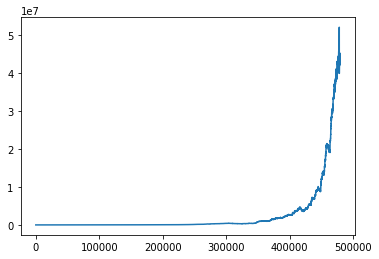

In [111]:
plt.plot(bankroll)

In [112]:
df = data.loc[data.FTR=='H']

In [120]:
len(data.loc[(data.avg_odds_home_win>=1.20) & (data.avg_odds_home_win<=1.20+0.0125) & (data.FTR=='H')])/len(data.loc[(data.avg_odds_home_win>=1.20) & (data.avg_odds_home_win<=1.20+0.0125)])

0.7835097001763669

In [123]:
len(data.loc[(data.avg_odds_home_win>=1.20) & (data.avg_odds_home_win<=1.20+0.0125)])

2268

In [121]:
1/1.2

0.8333333333333334

In [122]:
1/(1.2+0.0125)

0.8247422680412372

In [189]:
bins = np.linspace(1,15,14*80+1)

In [190]:
bins

array([ 1.    ,  1.0125,  1.025 , ..., 14.975 , 14.9875, 15.    ])

In [191]:
df = []
for i in range(1, len(bins)):
    theory_prob = (1/bins[i-1] + 1/bins[i])*0.5
    length = len(data.loc[(data.avg_odds_home_win>=bins[i-1]) & (data.avg_odds_home_win<=bins[i])])
    empirical_prob = len(data.loc[(data.avg_odds_home_win>=bins[i-1]) & (data.avg_odds_home_win<=bins[i]) & (data.FTR=='H')]) / length
    df.extend((theory_prob, empirical_prob, length))

ZeroDivisionError: division by zero

In [ ]:
df = np.array(df).reshape(int(len(df)/3), 3)

In [ ]:
df = pd.DataFrame(df, columns=['Theory Prob', 'Actual Prob', 'Nb obs'])

In [ ]:
df = df.loc[df['Nb obs']>=100]
df.dropna(inplace=True)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
y = df['Actual Prob'].values.reshape(-1,1)
X = df['Theory Prob'].values.reshape(-1,1)
reg = LinearRegression().fit(X, y)

In [ ]:
reg.score(X,y)

In [ ]:
reg.coef_

In [ ]:
reg.intercept_

In [185]:
df

,Theory Prob,Actual Prob,Nb obs
0,0.993827,0.988593,263.0
1,0.981632,0.972222,360.0
2,0.969733,0.954023,348.0
3,0.958118,0.904924,589.0
4,0.946779,0.905751,626.0
5,0.935705,0.920335,477.0
6,0.924886,0.895726,585.0
7,0.914316,0.885512,987.0
8,0.903984,0.866779,1186.0
9,0.893883,0.880734,1090.0


In [167]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)

ValueError: too many values to unpack (expected 4)

In [132]:
2/0.0125

160.0

In [103]:
bankroll

[1000,
 1000,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,
 1000.487146125322,

In [104]:
gains = np.array(gains).reshape(int(len(gains)/3), 3)

In [105]:
gains = pd.DataFrame(gains, columns=['Epsilon', 'Profit', 'Mise'])

In [106]:
gains.Mise.sum()

722.8794733620651

In [107]:
gains.Profit.sum()

34.40636832669941

In [108]:
34/722

0.04709141274238227

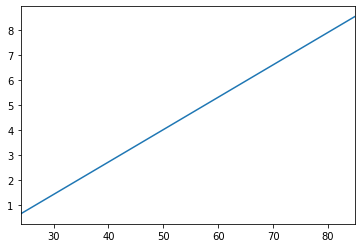

In [99]:
gains.Mise.loc[gains.Mise!=0].plot()

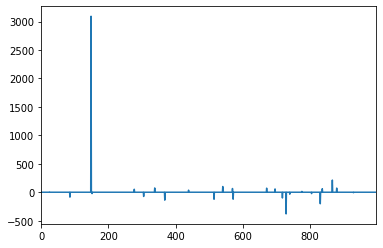

In [77]:
gains.Profit.plot()

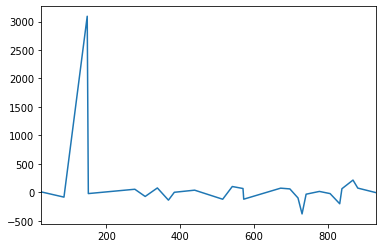

In [79]:
gains.Profit.loc[gains.Profit!=0].plot()

In [80]:
gains.loc[gains.Profit>800]

,Epsilon,Profit,Mise
148,2.176699,3092.85195,928.784369


In [82]:
data.iloc[148]

match_id                                170366
league                 Spain: Primera Division
match_date                          2005-01-05
home_team                          Real Madrid
home_score                                   2
away_team                        Real Sociedad
away_score                                   1
avg_odds_home_win                        1.944
avg_odds_draw                             3.56
avg_odds_away_win                        8.948
max_odds_home_win                         4.33
max_odds_draw                              4.2
max_odds_away_win                         9.99
top_bookie_home_win                Paddy Power
top_bookie_draw                    bet-at-home
top_bookie_away_win                Paddy Power
n_odds_home_win                              5
n_odds_draw                                  5
n_odds_away_win                              5
FTR                                          H
date                       2005-01-05 00:00:00
Prob. H      

In [44]:
gains.loc[gains.Epsilon>0].Profit.sum()

53416.5

In [ ]:
gains = []
for i in range(len(data)):
    home_prob = data['Prob. H'].iloc[i]
    odd = data.avg_odds_home_win.iloc[i]
    expected_return = home_prob*odd - 1
    if expected_return > 0:
        w= 50
    else:
        w=0
    result = data.FTR.iloc[i]
    if result == 'H':
        gain = w*(odd-1)
    else:
        gain = -w
    gains.append(gain)

In [27]:
np.sum(gains)

-2073346.9599999995

In [54]:
init_bankroll = 100
bankroll = [init_bankroll]
gains = []
a = 0.001
mises = []
gains = []
for i in range(len(data)):
    home_odd = data.avg_odds_home_win.iloc[i]
    away_odd = data.avg_odds_home_win.iloc[i]
    draw_odd = data.avg_odds_draw.iloc[i]
    max_home = data.max_odds_home_win.iloc[i]
    max_draw = data.max_odds_draw.iloc[i]
    max_away = data.max_odds_away_win.iloc[i]
    result = data.FTR.iloc[i]
    alpha_home = max_home - home_odd
    alpha_away = max_away - away_odd
    alpha_draw = max_draw - draw_odd
    idx = np.argmax([alpha_home, alpha_away, alpha_draw])
    if idx == 0 or alpha_home == alpha_away:
        bet = 'H'
        odd = max_home
        avg_odd = home_odd
        alpha = alpha_home
    elif idx == 1:
        bet = 'A'
        odd = max_away
        avg_odd = away_odd
        alpha = alpha_away
    else:
        bet = 'D'
        odd = max_draw
        avg_odd = draw_odd
        alpha = alpha_draw
    if (alpha >= 0.12) and (avg_odd <=2.0):
        w = alpha/avg_odd * a
    else:
        w = 0
    
    if result == bet:
        gain = w * bankroll[i] * (odd-1)
    else:
        gain = - w * bankroll[i]
    bankroll.append(bankroll[i]+gain)
    mises.append(bankroll[i]*w)
    gains.extend(())
    
        
    
    

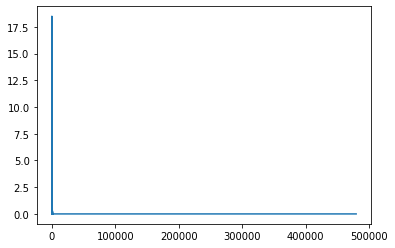

In [46]:
plt.plot(mises)

In [55]:
bankroll

[100,
 100,
 99.88669819078947,
 99.74390583603859,
 99.45573615200243,
 99.45573615200243,
 99.26267501711914,
 99.13113145068844,
 98.85785365708576,
 98.85785365708576,
 98.85785365708576,
 99.86290850259947,
 99.86290850259947,
 100.28951476645688,
 100.63307683913072,
 100.63307683913072,
 100.63307683913072,
 100.51315776257542,
 100.51315776257542,
 100.51315776257542,
 100.51315776257542,
 100.39881887574316,
 100.39881887574316,
 100.29027961209371,
 99.96405251060092,
 99.71846801882876,
 99.61446058444353,
 99.61446058444353,
 99.61446058444353,
 99.61446058444353,
 100.12996541796802,
 100.68878576694159,
 100.58727122938306,
 100.8588573932914,
 100.8588573932914,
 100.68087117436207,
 101.24097731905788,
 101.01993430997989,
 100.908275001863,
 101.39198313819519,
 101.39198313819519,
 102.46484698366098,
 102.46484698366098,
 102.25681229433052,
 102.25681229433052,
 102.25681229433052,
 102.25681229433052,
 102.25681229433052,
 102.53317142655784,
 102.8647614979369,
 1

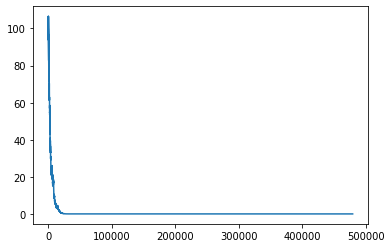

In [57]:
import matplotlib.pyplot as plt
plt.plot(bankroll)

In [25]:
data = data.loc[(data.avg_odds_home_win>1)]
data = data.loc[(data.avg_odds_away_win>1)]
data = data.loc[(data.avg_odds_draw>1)]

In [27]:
data.avg_odds_home_win.loc[data.FTR=='H'].mean()

2.0193152869355147

In [28]:
data.avg_odds_home_win.loc[data.FTR=='D'].mean()

2.4225184685248626

In [33]:
data.avg_odds_away_win.loc[data.FTR=='A'].max()

40.9365

In [34]:
data.loc[data.avg_odds_away_win==40.9365]

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,...,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,FTR,date
88381,347788,World: World Cup,2008-09-10,Switzerland,1,Luxembourg,2,1.03,11.0118,40.9365,...,14.0,67.0,Ladbrokes,Unibet,bet365,17,17,17,A,2008-09-10


In [21]:
data.avg_odds_home_win.loc[data.FTR=='H'].min()

0.0

In [19]:
data.avg_odds_home_win.loc[data.FTR=='H'].std()

0.8945353363374238

In [67]:
dates = data.date.unique()
historical = []
for d in dates:
    df = data.loc[data.date==d]
    bets = []
    for i in range(len(df)):
        home_odd = df.avg_odds_home_win.iloc[i]
        away_odd = df.avg_odds_way_win.iloc[i]
        odds = [home_odd, away_odd]
        idx = np.argmin(odds)
        result = df.FTR.iloc[i]
        if idx == 0:
            odd = home_odd
            bet = 'H'
        else:
            odd = away_odd
            bet = 'A'
        if odd >= 1.25 and odd <= 1.30:
            bets.extend((date, odd, bet, result))
        else:
            pass
        bets = np.array(bets).reshape((int(len(bets))/4, 4))
    historical.append(bets)

AttributeError: 'DataFrame' object has no attribute 'avg_odds'

In [142]:
df = data.loc[(data.avg_odds_home_win>=1.25) & (data.avg_odds_home_win<=1.30) | ((data.avg_odds_away_win<=1.30) & (data.avg_odds_home_win>=1.25))]

In [265]:
df = data.loc[(data.avg_odds_home_win>=1.98) & (data.avg_odds_home_win<=2.0)]

In [272]:
idx = [0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60]
n=2
m=2000
idx = (list(range(2,(m+1)*2,n)))
bets = []
for i in range(len(idx)):
    subdf = df.iloc[idx[i-1]:idx[i]]
    if len(subdf) != 2:
        pass
    else:
        if list(subdf.FTR) == ['H', 'H']:
            bets.append('win')
        else:
            bets.append('loss')
            

In [273]:
bets.count('win') / len(bets)

0.2226113056528264

In [274]:
1/1.99**2

0.252518875785965

In [251]:
len(bets)

2983

In [219]:
773/(773+1226)

0.38669334667333666

In [217]:
bets.count('loss')

1226

In [208]:
10 * (1.275**3-1)

10.726718749999996

In [220]:
10*(1.275**3-1) * 0.38 - 10 * 0.62

-2.1238468750000017

In [193]:
df.avg_odds_home_win.mean()

1.2758052602189027

In [189]:
201/(201+298)

0.4028056112224449

In [192]:
1/2.19

0.4566210045662101

In [179]:
8/20

0.4

In [180]:
1.25*1.25*1.25

1.953125

In [181]:
1/1.953125

0.512

In [182]:
10*0.25+10*0.25+10*0.25+10*0.25

10.0

In [169]:
list(subdf.FTR) == ['H', 'H', 'H']

True

In [ ]:
idx[]

In [153]:
df.iloc[10:13]

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,...,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,FTR,date
match_date,,,,,,,,,,,,,,,,,,,,,
2005-01-26,172209,Greece: Greek Cup,2005-01-26,Panionios,1,AO Ilisiakos,0,1.2500,4.5000,9.495,...,4.50,9.99,bet-at-home,bet-at-home,Expekt,2,2,2,H,2005-01-26
2005-01-29,172416,England: FA Cup,2005-01-29,Blackburn,3,Colchester,0,1.2600,4.8240,9.237,...,5.14,9.99,Expekt,Pinnacle Sports,bet365,10,10,10,H,2005-01-29
2005-01-29,172419,England: FA Cup,2005-01-29,Charlton,3,Yeovil,2,1.2513,4.9763,9.425,...,5.50,9.99,Pinnacle Sports,bet365,bet365,8,8,8,H,2005-01-29


In [145]:
for i in range(len(df)):
    h_odd = df.avg_odds_home_win.iloc[i]
    a_odd = df.avg_odds_away_win.iloc[i]
    odds = [h_odd, a_odd]
    result = df.FTR.iloc[i]
    if np.argmin(odds) == 0:
        bet = 'H'
        odd = h_odd
    else:
        bet = 'A'
        odd = a_odd
    

18390

In [112]:
df=data.loc[(data.avg_odds_home_win<=1.15)]
gains = []
for i in range(len(df)):
    result = df.FTR.iloc[i]
    bet = 'H'
    odd = df.avg_odds_home_win.iloc[i]
    if bet == result:
        gain = 100 * (odd-1)
    else:
        gain = -100
    gains.append(gain)

In [120]:
np.sum((df.FTR=='H')*(df.avg_odds_home_win-1)*100) + np.sum((df.FTR!='H'))*(-100)

-24765.199999999997

In [133]:
np.sum((data.loc[(data.FTR=='H') & (data.avg_odds_home_win<=1.25)].avg_odds_home_win - 1)*100)

287226.7

In [136]:
data.loc[(data.FTR!='H') & (data.avg_odds_home_win<=1.25)]

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,...,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,FTR,date
match_date,,,,,,,,,,,,,,,,,,,,,
2005-01-08,170567,England: FA Cup,2005-01-08,Manchester United,0,Exeter,0,1.0400,8.5000,9.9900,...,9.50,9.99,bet-at-home,Pinnacle Sports,bet-at-home,9,9,9,D,2005-01-08
2005-01-08,170589,France: Coupe de France,2005-01-08,Marseille,2,Angers,3,1.1988,4.9750,9.9900,...,5.00,9.99,bet-at-home,bet-at-home,bet-at-home,8,8,8,A,2005-01-08
2005-01-08,170597,France: Coupe de France,2005-01-08,Troyes,1,Albi,3,1.2250,4.6250,9.9900,...,5.00,9.99,Pinnacle Sports,bet-at-home,bet-at-home,2,2,2,A,2005-01-08
2005-01-13,170960,Italy: Coppa Italia,2005-01-13,Juventus,3,Atalanta,3,1.2390,4.8830,9.6120,...,5.78,9.99,bet-at-home,Pinnacle Sports,bet-at-home,10,10,10,D,2005-01-13
2005-01-15,171168,Scotland: Division 3,2005-01-15,Peterhead,0,East Fife,0,1.2013,5.5338,9.1088,...,6.00,9.99,Paddy Power,BetVictor,Ladbrokes,8,8,8,D,2005-01-15
2005-01-19,171585,Spain: Copa del Rey,2005-01-19,Betis,0,Mirandes,0,1.2170,5.0200,9.4550,...,5.50,9.99,bet-at-home,Paddy Power,bet365,10,10,10,D,2005-01-19
2005-01-19,171588,Spain: Copa del Rey,2005-01-19,Real Madrid,1,Valladolid,1,1.2170,5.1990,9.5870,...,6.00,9.99,bet-at-home,Sportingbet,bet365,10,10,10,D,2005-01-19
2005-01-22,171857,Portugal: Primeira Liga,2005-01-22,Benfica,0,Beira Mar,2,1.2280,5.0250,9.1790,...,5.30,9.99,Expekt,Pinnacle Sports,bet-at-home,10,10,10,A,2005-01-22
2005-01-30,172708,Netherlands: Eredivisie,2005-01-30,Ajax,0,Den Haag,0,1.1410,6.1090,9.9900,...,7.00,9.99,William Hill,BetVictor,bet-at-home,10,10,10,D,2005-01-30


In [126]:
len(data.loc[data.FTR=='H']) / len(data)

0.4524111463373936

In [127]:
len(data.loc[data.FTR=='A']) / len(data)

0.2977244284999166

In [124]:
len(data.FTR=='H') / len(data)

1.0

In [ ]:
w = 

In [113]:
len(gains)

8622

In [114]:
np.sum(gains)

-24765.2

In [104]:
data.loc[(data.avg_odds_home_win>=1.25) & (data.avg_odds_home_win<=1.30)]

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,...,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,FTR,date
match_date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,170183,Northern Ireland: IFA Premiership,2005-01-01,Coleraine,3,Omagh Town,4,1.2900,4.5000,8.0000,...,4.50,8.00,Paddy Power,Paddy Power,Paddy Power,1,1,1,A,2005-01-01
2005-01-01,170200,Wales: Premier,2005-01-01,Bangor,2,Caernarfon,0,1.2900,4.5000,8.0000,...,4.50,8.00,bet365,bet365,bet365,1,1,1,H,2005-01-01
2005-01-04,170329,England: Premier League,2005-01-04,Arsenal,1,Manchester City,1,1.2733,4.8144,9.5489,...,5.00,9.99,Expekt,bet365,bet-at-home,9,9,9,D,2005-01-04
2005-01-06,170380,Italy: Serie A,2005-01-06,AC Milan,5,Lecce,2,1.2700,4.5138,9.3713,...,5.00,9.99,William Hill,Pinnacle Sports,bet-at-home,8,8,8,H,2005-01-06
2005-01-08,170631,Scotland: Division 3,2005-01-08,Cowdenbeath,3,East Stirlingshire,2,1.2614,4.9400,8.0000,...,5.25,8.00,Ladbrokes,Pinnacle Sports,bet365,7,7,7,H,2005-01-08
2005-01-09,170676,Greece: Super League,2005-01-09,PAOK,5,Kalamaria,2,1.2950,4.4183,8.2483,...,4.55,9.99,bet365,Expekt,Coral,6,6,6,H,2005-01-09
2005-01-11,170878,England: Carling Cup,2005-01-11,Liverpool,1,Watford,0,1.2733,4.8100,9.0611,...,5.50,9.99,bet-at-home,bet365,bet365,9,9,9,H,2005-01-11
2005-01-12,170914,Greece: Greek Cup,2005-01-12,Skoda Xanthi,3,Levadiakos,0,1.2500,4.5000,8.7450,...,4.50,9.99,bet-at-home,bet-at-home,Expekt,2,2,2,H,2005-01-12
2005-01-21,171647,Netherlands: Eredivisie,2005-01-21,AZ Alkmaar,1,Nijmegen,1,1.2850,4.4940,8.3340,...,4.75,9.99,Coral,Expekt,bet-at-home,10,10,10,D,2005-01-21


In [92]:
dates = data.date.unique()
historical = []
for d in dates:
    df = data.loc[data.date==d]
    bets = []
    for i in range(len(df)):
        home_odd = df.avg_odds_home_win.iloc[i]
        away_odd = df.avg_odds_away_win.iloc[i]
        odds = [home_odd, away_odd]
        idx = np.argmin(odds)
        result = df.FTR.iloc[i]
        if idx == 0:
            odd = home_odd
            bet = 'H'
        else:
            odd = away_odd
            bet = 'A'
        if odd >= 1.25 and odd <= 1.30:
            bets.extend((odd, bet, result))
        else:
            pass
    bets = np.array(bets).reshape((int(len(bets)/3), 3))
    historical.append(bets)
    

In [100]:
historical

[array([['1.29', 'H', 'A'],
        ['1.2771', 'A', 'A'],
        ['1.29', 'H', 'H']], dtype='<U32'),
 array([], shape=(0, 3), dtype=float64),
 array([['1.2643', 'A', 'D']], dtype='<U32'),
 array([['1.2733', 'H', 'D']], dtype='<U32'),
 array([['1.25', 'A', 'A']], dtype='<U32'),
 array([['1.27', 'H', 'H']], dtype='<U32'),
 array([], shape=(0, 3), dtype=float64),
 array([['1.285', 'A', 'A'],
        ['1.295', 'A', 'A'],
        ['1.2614', 'H', 'H']], dtype='<U32'),
 array([['1.295', 'H', 'H']], dtype='<U32'),
 array([], shape=(0, 3), dtype=float64),
 array([['1.2733', 'H', 'H']], dtype='<U32'),
 array([['1.25', 'H', 'H']], dtype='<U32'),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([['1.25', 'A', 'A']], dtype='<U32'),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([['1.285', 'H', 'D

In [85]:
np.array(bets).reshape((int(len(bets)/3),3))

array([['1.2994', 'H', 'H'],
       ['1.2933', 'A', 'A']], dtype='<U32')

In [64]:
dates = data.date.unique()
for d in dates:
    df = data.loc[data.date==d]
    bets = []
    for i in range(len(df)):
        home_odd = df.avg_odds_home_win.iloc[i]
        away_odd = df.avg_odds.away_win.iloc[i]
        odds = [home_odd, away_odd]
        idx = np.argmin(odds)
        result = df.FTR.iloc[i]
        if idx == 0:
            odd = home_odd
            bet = 'H'
        else:
            odd = away_odd
            bet = 'A'
        if odd >= 1.25 and odd <= 1.30:
            bets.extend((date, odd, bet, result)
        else:
                        

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,...,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,FTR,date
match_date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,170088,England: Premier League,2005-01-01,Liverpool,0,Chelsea,1,2.9944,3.1944,2.2256,...,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9,A,2005-01-01
2005-01-01,170089,England: Premier League,2005-01-01,Fulham,3,Crystal Palace,1,1.9456,3.2333,3.6722,...,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9,H,2005-01-01
2005-01-01,170090,England: Premier League,2005-01-01,Aston Villa,1,Blackburn,0,1.8522,3.2611,4.0144,...,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9,H,2005-01-01
2005-01-01,170091,England: Premier League,2005-01-01,Bolton,1,West Brom,1,1.6122,3.4133,5.4722,...,3.57,6.27,Coral,Pinnacle Sports,Pinnacle Sports,9,9,9,D,2005-01-01
2005-01-01,170092,England: Premier League,2005-01-01,Charlton,1,Arsenal,3,5.9878,3.4778,1.5567,...,3.60,1.62,Expekt,Paddy Power,bet365,9,9,9,A,2005-01-01
2005-01-01,170093,England: Premier League,2005-01-01,Manchester City,2,Southampton,1,1.7000,3.3667,4.7344,...,3.50,5.00,bet365,Expekt,bet365,9,9,9,H,2005-01-01
2005-01-01,170094,England: Premier League,2005-01-01,Newcastle Utd,2,Birmingham,1,1.8622,3.2500,3.9622,...,3.40,4.33,bet365,Sportingbet,bet365,9,9,9,H,2005-01-01
2005-01-01,170095,England: Premier League,2005-01-01,Portsmouth,1,Norwich,1,1.6344,3.3933,5.2633,...,3.54,6.14,William Hill,Pinnacle Sports,Pinnacle Sports,9,9,9,D,2005-01-01
2005-01-01,170096,England: Premier League,2005-01-01,Tottenham,5,Everton,2,2.2156,3.1722,3.0444,...,3.20,3.35,Expekt,bet365,Pinnacle Sports,9,9,9,H,2005-01-01


In [56]:
n=7
m=1000
idx = list(range(n, (m+1)*n, n))
idx.insert(1,0)
for i in idx:
    df = data.loc[(data.index>=dates[i]) & (data.index<=dates[i+1])]

IndexError: index 3830 is out of bounds for axis 0 with size 3830

In [24]:
df = data.loc[data.index==dates[0]]

In [25]:
df

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,FTR
match_date,,,,,,,,,,,,,,,,,,,,
2005-01-01,170088,England: Premier League,2005-01-01,Liverpool,0,Chelsea,1,2.9944,3.1944,2.2256,3.20,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9,A
2005-01-01,170089,England: Premier League,2005-01-01,Fulham,3,Crystal Palace,1,1.9456,3.2333,3.6722,2.04,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9,H
2005-01-01,170090,England: Premier League,2005-01-01,Aston Villa,1,Blackburn,0,1.8522,3.2611,4.0144,2.00,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9,H
2005-01-01,170091,England: Premier League,2005-01-01,Bolton,1,West Brom,1,1.6122,3.4133,5.4722,1.67,3.57,6.27,Coral,Pinnacle Sports,Pinnacle Sports,9,9,9,D
2005-01-01,170092,England: Premier League,2005-01-01,Charlton,1,Arsenal,3,5.9878,3.4778,1.5567,7.00,3.60,1.62,Expekt,Paddy Power,bet365,9,9,9,A
2005-01-01,170093,England: Premier League,2005-01-01,Manchester City,2,Southampton,1,1.7000,3.3667,4.7344,1.73,3.50,5.00,bet365,Expekt,bet365,9,9,9,H
2005-01-01,170094,England: Premier League,2005-01-01,Newcastle Utd,2,Birmingham,1,1.8622,3.2500,3.9622,1.91,3.40,4.33,bet365,Sportingbet,bet365,9,9,9,H
2005-01-01,170095,England: Premier League,2005-01-01,Portsmouth,1,Norwich,1,1.6344,3.3933,5.2633,1.70,3.54,6.14,William Hill,Pinnacle Sports,Pinnacle Sports,9,9,9,D
2005-01-01,170096,England: Premier League,2005-01-01,Tottenham,5,Everton,2,2.2156,3.1722,3.0444,2.29,3.20,3.35,Expekt,bet365,Pinnacle Sports,9,9,9,H


In [ ]:
for date in dates:
    df = data.loc[data.index==date]
    

In [21]:
import datetime
dates[0] < dates[1] + datetime.timedelta(days=1)

True

In [22]:
dates[]

DatetimeIndex(['2005-01-01', '2005-01-02', '2005-01-03', '2005-01-04',
               '2005-01-05', '2005-01-06', '2005-01-07', '2005-01-08',
               '2005-01-09', '2005-01-10',
               ...
               '2015-06-21', '2015-06-22', '2015-06-23', '2015-06-24',
               '2015-06-25', '2015-06-26', '2015-06-27', '2015-06-28',
               '2015-06-29', '2015-06-30'],
              dtype='datetime64[ns]', name='match_date', length=3830, freq=None)

In [19]:
def odd_to_prob(margin, odd1, odd2, odd3):
    
    return ( 1/(odd1 + margin) + 1/(odd2 + margin) + 1/(odd3 + margin) - 1)

In [47]:
def calculate_margin(odd1, odd2, odd3):
    from scipy import optimize
    margin_ = optimize.newton(func=odd_to_prob, x0=0.05, args=(odd1,odd2,odd3))
    return margin_
    

In [54]:
def implied_prob(odd):
    return 1/odd

In [55]:
def fair_odd(odd):
    return odd + margin

In [77]:
def expected_gain(odd1, odd2, odd3, bet):
    margin = calculate_margin(odd1, odd2, odd3)
    fair_odds = [fair_odd(odd1), fair_odd(odd2), fair_odd(odd3)]
    fair_probs = [1/x for x in fair_odds]
    
    if bet == '1':
        return fair_probs[0] * (odd1-1) - fair_probs[1] - fair_probs[2]
    elif bet == '2' :
        return fair_probs[1] * (odd2-1) - fair_probs[0] - fair_probs[2]
    else:
        return fair_probs[2] * (odd3-1) - fair_probs[0] - fair_probs[1]


In [109]:
odd1, odd2, odd3 = [3.75, 3.40, 2.10]
margin = calculate_margin(odd1, odd2, odd3)
fair_odds = [fair_odd(odd1), fair_odd(odd2), fair_odd(odd3)]


In [112]:
expected_gain(odd1, odd2, odd3, '3')

-0.04545454545454203

In [104]:
data.head()

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,...,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,FTR,Profits
0,170088,England: Premier League,2005-01-01,Liverpool,0,Chelsea,1,2.9944,3.1944,2.2256,...,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9,A,0.0
1,170089,England: Premier League,2005-01-01,Fulham,3,Crystal Palace,1,1.9456,3.2333,3.6722,...,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9,H,0.0
2,170090,England: Premier League,2005-01-01,Aston Villa,1,Blackburn,0,1.8522,3.2611,4.0144,...,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9,H,0.0
3,170091,England: Premier League,2005-01-01,Bolton,1,West Brom,1,1.6122,3.4133,5.4722,...,3.57,6.27,Coral,Pinnacle Sports,Pinnacle Sports,9,9,9,D,0.0
4,170092,England: Premier League,2005-01-01,Charlton,1,Arsenal,3,5.9878,3.4778,1.5567,...,3.60,1.62,Expekt,Paddy Power,bet365,9,9,9,A,0.0


In [ ]:
data

In [18]:
profits = []
for i in range(len(data)):
    home_margin = data['max_odds_home_win'].iloc[i] - data['avg_odds_home_win'].iloc[i]
    away_margin = data['max_odds_away_win'].iloc[i] - data['avg_odds_away_win'].iloc[i]
    draw_margin = data['max_odds_draw'].iloc[i] - data['avg_odds_draw'].iloc[i]
    best_margin = max(home_margin, away_margin, draw_margin)
    idx = np.argmax([home_margin, away_margin, draw_margin])
    if idx == 0:
        bet = 'H'
        best_odd = data['max_odds_home_win'].iloc[i]
        avg_odd = data['avg_odds_home_win'].iloc[i]
    elif idx == 1:
        bet = 'A'
        best_odd = data['max_odds_away_win'].iloc[i]
        avg_odd = data['avg_odds_away_win'].iloc[i]
    else:
        bet = 'D'
        best_odd = data['max_odds_draw'].iloc[i]
        avg_odd = data['avg_odds_draw'].iloc[i]
        
    if (best_odd > avg_odd + 0.05) & (avg_odd < 2.0):
        mise = 50
    else:
        mise = 0
    
    result = data.FTR.iloc[i]
    
    if bet == result:
        profit = mise * (best_odd - 1)
    else:
        profit = - mise
    profits.append(profit)
        
    
        
    

In [19]:
profits

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0,
 0.0,
 0,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0,
 0.0,
 0,
 0.0,
 0,
 0,
 0.0,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0.0,
 0,
 0.0,
 0.0,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0.0,
 0.0,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 166.5,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0.0,
 0.0,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0.0,
 0,
 0,
 0.0,


In [20]:
np.sum(profits)

4749.0

In [21]:
len(profits)

479440

In [22]:
len(data)

479440

In [23]:
data['Profits'] = profits

In [24]:
2.04-1.9456

0.09440000000000004

In [25]:
4.15-3.6722

0.4778000000000002

In [26]:
data[['max_odds_home_win', 'avg_odds_home_win', 'max_odds_away_win', 'avg_odds_away_win', 'max_odds_draw', 'avg_odds_draw','FTR', 'Profits']]

,max_odds_home_win,avg_odds_home_win,max_odds_away_win,avg_odds_away_win,max_odds_draw,avg_odds_draw,FTR,Profits
0,3.20,2.9944,2.29,2.2256,3.25,3.1944,A,0.0
1,2.04,1.9456,4.15,3.6722,3.30,3.2333,H,0.0
2,2.00,1.8522,4.50,4.0144,3.40,3.2611,H,0.0
3,1.67,1.6122,6.27,5.4722,3.57,3.4133,D,0.0
4,7.00,5.9878,1.62,1.5567,3.60,3.4778,A,0.0
5,1.73,1.7000,5.00,4.7344,3.50,3.3667,H,0.0
6,1.91,1.8622,4.33,3.9622,3.40,3.2500,H,0.0
7,1.70,1.6344,6.14,5.2633,3.54,3.3933,D,0.0
8,2.29,2.2156,3.35,3.0444,3.20,3.1722,H,0.0
9,3.75,3.3611,2.10,2.0489,3.25,3.2222,A,0.0
